<a href="https://colab.research.google.com/github/juanlestrella/ImageAnalysis/blob/main/FinalProject_Juan_Estrella.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**: 

For my final project I choose to work on a challenge I found in zindi.africa titled "Local Ocean Conversation - Sea Turtle Face Detection."  This challenge is created by the organization Local Ocean Conversation (LOC), a not-for-profit committed to protect Kenya's marine environment. LOC's mission is to develop sustainable marine resource management models that utilize sea turtles as flagship species for Kenya's ocean health. For this specific challenge, LOC wants to use the unique fingerprint of tutle's faces to integrate facial image recognication. In order to do this, an algorithm is required to take an image of a sea turtle and output the position of a bounding box around all-important scale pattern.

The Sea Turtle Face Detection challenge provided a csv file called Train.csv. This csv file contains the list of image id and bounding box annotations. The bounding boxes are defined by four numbers: x, y, w (width), and h (height). These are float numbers representing the fractions of the image dimensions in pixels. In addition, the challenge provides two zip files, IMAGES_1024 and IMAGES_512, which contains different pixel version of the images. Finally, we are also provided by a starter notebook to help show how to convert the pixel locations to the input image size and some other functionality that might be useful in developing the algorithm.


**Methods**:

In order to implement this algorithm, I decided to use a supervised segmentation called active contour. This segmentation method is used to fit a snake on objects to outline its shape. In order to use active contour, we first need to initialize the snake. Since the challenge provided us with a bounding box, we can use this box to create a circle around the turtle's head. We cannot use the coordinates of the bounding box since the coordinates required for the snake is polar coordinate. In order to generate an array that contains the circle, I used the function circle_points provided by in lecture 14. This function requires three arguments: resolution, center, and radius. The resolution is a allows 200, this is not a good general number of points to give for all the images as each images contains different shape of the bounding box. The center is calculated by finding the middle point from two of the diagonal corners' coordinate from the bounding box. The radius is computed by the distance between the center point and one of the bounding box's corners.

**Results**

The result of the active contour method on each of the images varies. Mostly, the snake does not fit the turtle's head because the background and the turtle's head does not have a good contrast. This can be improved by having a plain one colored background when the images are taken. Moreover, using the dataframe generated from Train.csv, I inserted four more columns in the dataframe: 
*   resolution: points for the snake (all 200)
*   center: the center of the provided bounding box
*   radius: the radius of the circle covering the turtles' head
*   points: array result from circle_points function

Lastly, I generated a simple histogram using matplotlib in order to show the radius used for the circle_points function. The radius indicates the maximum radius of each turtle's head. This shows how far or close the images are usually photographed.

**Discussion**

The result from active contour could definitely be improved. For example, another user who participated in the challenge used libraries like segmentation_models_pytorch and albumentations to develop an algorithm for this challenge. The result could also be used to generate random forest regression or convolutional neural network to predict how well the algorithm works on detecting turtle's face.

Import libraries and define helper functions image_show, circle_points

In [ ]:
from PIL import Image, ImageDraw
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import skimage.segmentation as seg
from skimage import color
from skimage import exposure
from skimage.draw import rectangle_perimeter
import glob
from skimage import io
#moon = io.imread(filename)

def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center, radius):
  """
  Generate points defining a circle on an image.
  """
  radians = np.linspace(0, 2*np.pi, resolution)

  c = center[1] + radius*np.cos(radians)
  r = center[0] + radius*np.sin(radians)
  
  return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
#points = circle_points(200, [100, 220], 100)[:-1]

Unzip the IMAGES zip file

In [ ]:
!cp '/content/IMAGES_512.zip' .
!unzip -q IMAGES_512.zip
image_folder = 'IMAGES_512'

cp: '/content/IMAGES_512.zip' and './IMAGES_512.zip' are the same file
replace IMAGES_512/974873B6.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Load train - edit path to suit your setup

In [ ]:
train = pd.read_csv('/content/Train.csv')
print(train.shape)
train.head()

(1326, 5)


,Image_ID,x,y,w,h
0,04FB1B33,0.481988,0.506076,0.174696,0.405671
1,B04E481E,0.617405,0.313368,0.177734,0.293113
2,32655645,0.490885,0.465856,0.165582,0.357350
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722
4,4F36EF72,0.433811,0.574363,0.180773,0.397569


Sample Image

(<Figure size 1152x1152 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f86f980d9e8>)

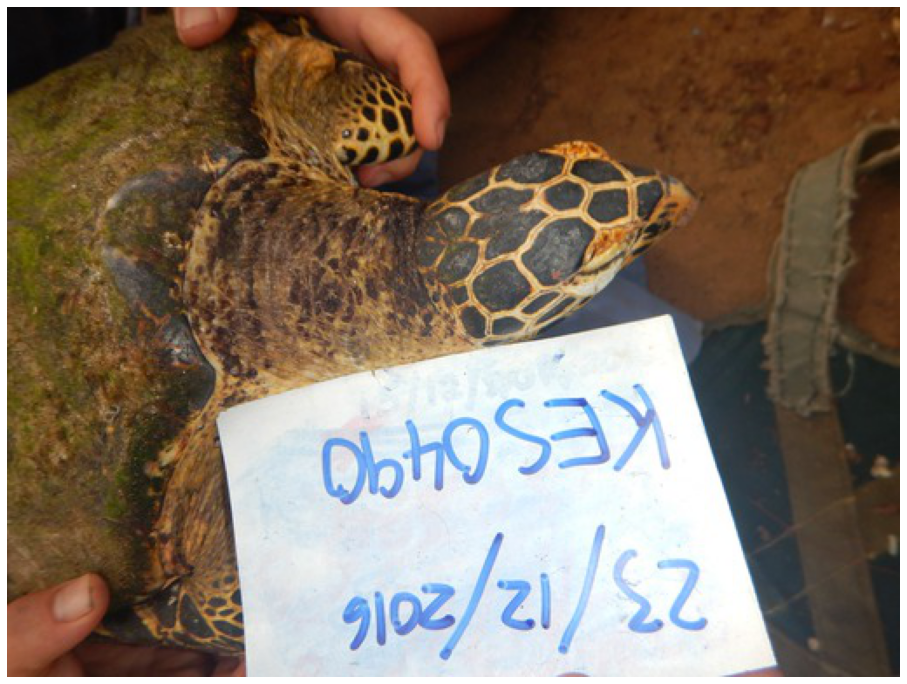

In [ ]:
# Take a sample row
imid, x1, y1, w, h = train.sample().values[0]

# Open with PIL and draw a bounding box
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  #draw.rectangle([int(x1*imw), int(y1*imh), int((x1+w)*imw), int((y1+h)*imh)], width=2)

image_show(im)


A8198D3E


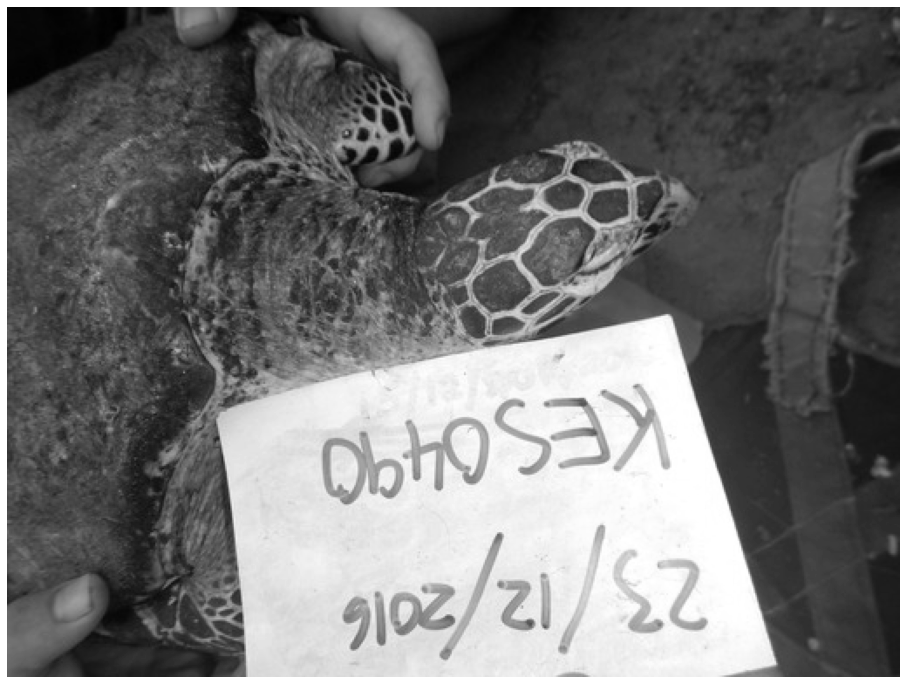

In [ ]:
im_gray = im.convert('L')
image_show(im_gray)
print(imid)
#images with good contrast:
#068C94DD

**SUPERVISED SEGMENTATION: ACTIVE CONTOUR**

Since the bounding box for the training set images are given I thought it would be a good idea to use active contour segmentation. I could use the bounding box,given as x, y, w(width), and h(height), as the initial snake coordinate to find a fitted snake around the turtles' head. 

Create a mask using the bounding box and determining arguments for the circle_points helper function

96


(<Figure size 1152x1152 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f86f9741be0>)

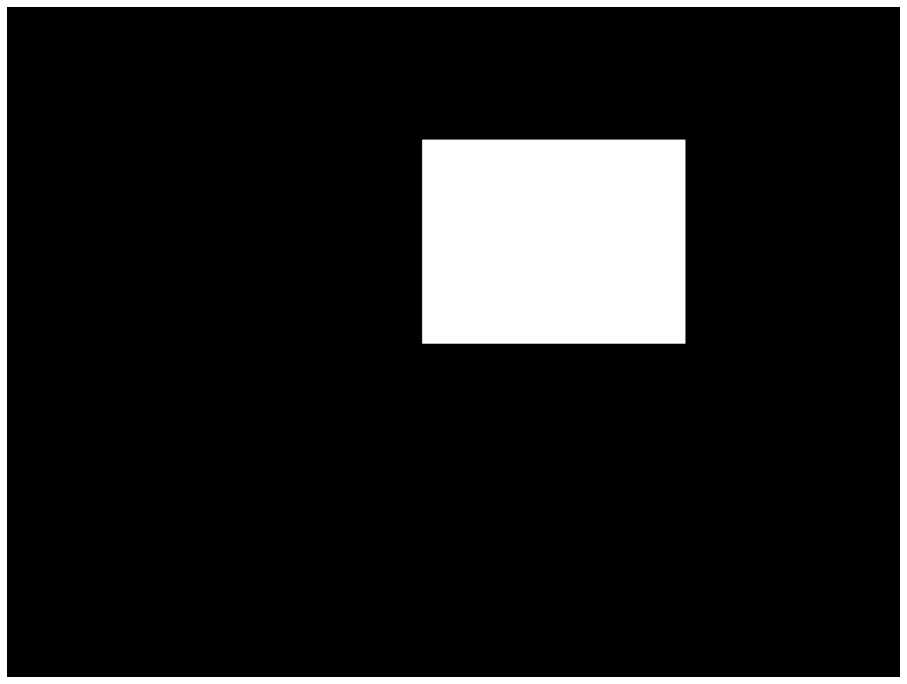

In [ ]:
mask = np.zeros((im.size[1], im.size[0]))
mask[int(y1*imh):int((y1+h)*imh), int(x1*imw):int((x1+w)*imw)] = 1 #to show where box is located
#center
xtop_right = (x1+w)*imw
ytop_right = y1*imh
#mask[int(ytop_right),int(xtop_right)] = 255

xcenter=int((xtop_right+x1*imw)/2)
ycenter=int((ytop_right+((y1+h)*imh))/2)
#mask[ycenter,xcenter] = 255 # this is the center 

#radius
#print(int(((y1+h)*imh-(y1*imh))/2))
#print(int(((x1+w)*imw-(x1*imw))/2))
#print(max(int(((y1+h)*imh-(y1*imh))/2), int(((x1+w)*imw-(x1*imw))/2)))
#rather than using the max of width or height, use the distance between the center and one of diagonal corners
radius = int(((xtop_right - xcenter)**2 + (ytop_right - ycenter)**2)**0.5)
print(radius)
image_show(mask)

In [ ]:
#circle_points(resolution, center, radius):
resolution = 200
center = [ycenter,xcenter]
radius = int(((xtop_right - xcenter)**2 + (ytop_right - ycenter)**2)**0.5)
points = circle_points(resolution, center, radius)[:-1]
snake = seg.active_contour(im_gray, points, alpha=.15, w_edge=1.3) 
print(points)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  


[[409.         135.        ]
 [408.95215256 138.03058078]
 [408.80865792 141.05814061]
 [408.56965913 144.07966155]
 [408.23539442 147.09213169]
 [407.80619701 150.09254812]
 [407.28249471 153.07791998]
 [406.66480957 156.04527138]
 [405.95375732 158.99164439]
 [405.15004674 161.914102  ]
 [404.25447898 164.80973106]
 [403.26794678 167.67564513]
 [402.19143352 170.5089874 ]
 [401.02601231 173.30693354]
 [399.77284485 176.0666945 ]
 [398.43318033 178.78551928]
 [397.00835416 181.46069771]
 [395.49978663 184.0895631 ]
 [393.90898153 186.66949495]
 [392.23752459 189.19792152]
 [390.48708196 191.67232243]
 [388.65939853 194.09023113]
 [386.75629616 196.4492374 ]
 [384.77967191 198.74698974]
 [382.73149612 200.98119769]
 [380.61381046 203.14963415]
 [378.42872589 205.25013757]
 [376.17842053 207.28061413]
 [373.86513756 209.2390398 ]
 [371.49118289 211.12346238]
 [369.05892294 212.93200343]
 [366.57078223 214.66286017]
 [364.02924101 216.31430724]
 [361.43683272 217.88469844]
 [358.79614155

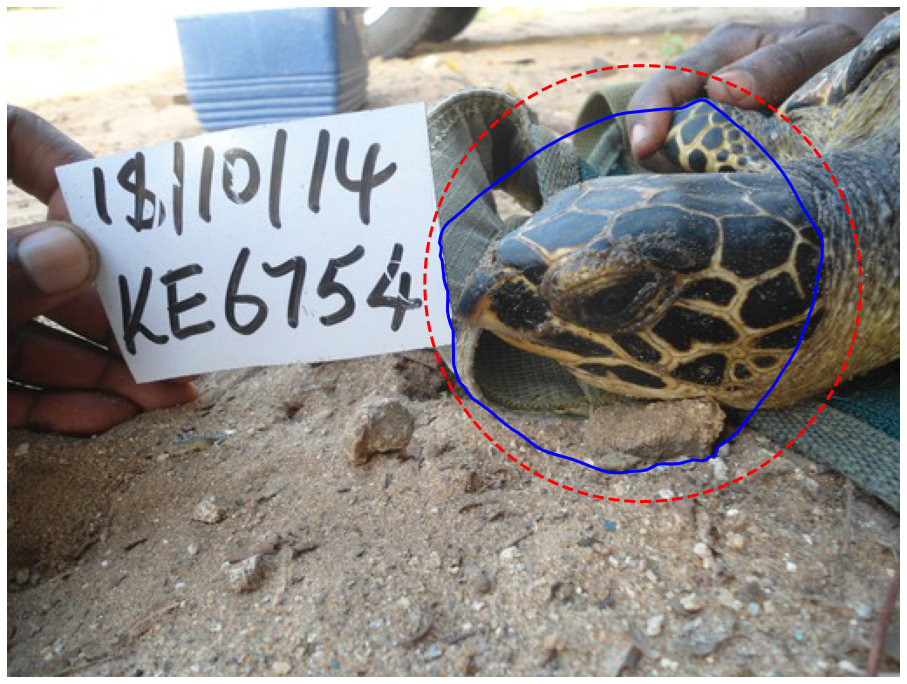

In [ ]:
fig, ax = image_show(im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)

As seen above it is difficult to fit a good snake on the turtle's head because the contrast to its background is poor. What I have found on other people's code is that they would use torch to help darken the head area. Another idea is that when pictures are taken, have the turtle on a plain background to help with the contrast. In addition, each images have different resolution therefore I can't figure out the general amount of points to assign to the snake.

**Use the train DataFrame to add the following columns to Train.csv**

Columns:

*   resolution: points for the snake (all 200)
*   center: the center of the provided bounding box
*   radius: the radius of the circle covering the turtles' head
*   points: array result from circle_points function




In [ ]:
#train_sampled = pd.DataFrame([process_im(fid) for fid in train['Image_ID'].values])
imid_array = train['Image_ID'].values
print(imid_array)
res_col = []
center_col = []
radius_col = []
points_col = []
for i in range(len(train)):
  imid = train.loc[i, "Image_ID"]
  x = train.loc[i, "x"]
  y = train.loc[i, "y"]
  w = train.loc[i, "w"]
  h = train.loc[i, "h"]

  with Image.open(f'{image_folder}/{imid}.JPG') as im:
    imw, imh = im.size

  xtop_right = (x1+w)*imw
  ytop_right = y1*imh
  xcenter=int((xtop_right+x1*imw)/2)
  ycenter=int((ytop_right+((y1+h)*imh))/2)

  resolution = 200
  center = [ycenter,xcenter]
  radius = int(((xtop_right - xcenter)**2 + (ytop_right - ycenter)**2)**0.5)
  points = circle_points(resolution, center, radius)[:-1]
  #snake = seg.active_contour(im_gray, points, alpha=.15, w_edge=1.3)
  
  res_col.append(resolution)
  center_col.append(center)
  radius_col.append(radius)
  points_col.append(points)

['04FB1B33' 'B04E481E' '32655645' ... '12316396' 'F6A8DD00' '780FB6A5']


In [ ]:
train['resolution'] = res_col
train['center'] = center_col
train['radius'] = radius_col
train['points'] = points_col
train

,Image_ID,x,y,w,h,resolution,center,radius,points
0,04FB1B33,0.481988,0.506076,0.174696,0.405671,200,"[154, 282]",89,"[[371.0, 154.0], [370.95564143222947, 156.8096..."
1,B04E481E,0.617405,0.313368,0.177734,0.293113,200,"[133, 283]",72,"[[355.0, 133.0], [354.9641144170845, 135.27293..."
2,32655645,0.490885,0.465856,0.165582,0.357350,200,"[145, 280]",80,"[[360.0, 145.0], [359.9601271300939, 147.52548..."
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722,200,"[155, 299]",99,"[[398.0, 155.0], [397.9506573234912, 158.12528..."
4,4F36EF72,0.433811,0.574363,0.180773,0.397569,200,"[153, 284]",89,"[[373.0, 153.0], [372.95564143222947, 155.8096..."
...,...,...,...,...,...,...,...,...,...
1321,7FF4C9A4,0.560764,0.238715,0.320964,0.445891,200,"[162, 320]",118,"[[438.0, 162.0], [437.9411875168885, 165.72508..."
1322,FD746AE7,0.324870,0.563079,0.240234,0.206887,200,"[116, 299]",73,"[[372.0, 116.0], [371.9636160062107, 118.30450..."
1323,12316396,0.282552,0.544560,0.195095,0.214988,200,"[118, 288]",64,"[[352.0, 118.0], [351.96810170407514, 120.0203..."
1324,F6A8DD00,0.172095,0.397300,0.346391,0.366197,200,"[147, 326]",113,"[[439.0, 147.0], [438.94367957125763, 150.5672..."


Text(0, 0.5, 'Frequency')

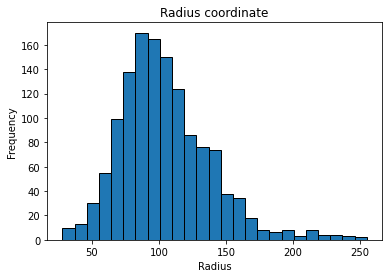

In [ ]:
plt.hist(radius_col, edgecolor='black', bins=25)
plt.title("Radius coordinate")
plt.xlabel('Radius')
plt.ylabel('Frequency')

FEEDBACK FROM PRESENTATION:

use circle_points from lecture14, use that as the mask for turtle's head.

circle_points: resolution: 200, center: compute from bounding box, 
radius from height and width of the bounding box

identify the head consistantly -> can already do this since I have the bounding box -> use active_contour

Identify the location of the head -> can also already do this since I have the bounding box.

Create a dataset that computes the size of the turtle's head

measure the size of the head -> done by the return of the active_contour's shape

the data could be used to create a random forest regression


problem with this might be I don't have any other subject to compare the size of the turtle's head. Depending on how the picture was taken, could be side-ways, closer vs far image, ...